In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import glob
from torchvision.models import Inception_V3_Weights
from tqdm import tqdm

def load_inceptionv3_model(device):
    """Load pre-trained InceptionV3 model properly configured for feature extraction."""
    model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
    model.fc = torch.nn.Identity()  # Replace final FC layer with identity
    model.aux_logits = False  # Disable auxiliary classifiers
    model.eval()
    model.to(device)
    print(f"InceptionV3 model loaded on device: {device}")
    return model

def preprocess_image(image_path, device):
    """Preprocess image for InceptionV3 with ImageNet normalization."""
    transform = transforms.Compose([
        transforms.Resize((299, 299)),  # InceptionV3 requires 299x299
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet standard
    ])
    try:
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)  # Add batch dim and move to device
        return image
    except Exception as e:
        print(f"Error loading {image_path}: {str(e)}")
        return None

def extract_features(model, image_path, device):
    """Extract features from a single image."""
    image = preprocess_image(image_path, device)
    if image is None:
        return None
    with torch.no_grad():
        features = model(image)
    return features.squeeze().cpu().numpy()

def process_video_frames(folder_path, output_dir, device, batch_size=None):
    """Process all frames in the folder and save features."""
    folder_name = os.path.basename(folder_path)
    model = load_inceptionv3_model(device)

    frame_paths = sorted(glob.glob(os.path.join(folder_path, 'frame_*.jpg')))
    if not frame_paths:
        print(f"No frames found in {folder_path}")
        return

    features_list = []
    if batch_size is None:
        # Single-image processing (as in your original code)
        for frame_path in tqdm(frame_paths, desc=f"Processing {folder_name}"):
            features = extract_features(model, frame_path, device)
            if features is not None:
                features_list.append(features)
    else:
        # Batch processing (optional, uncomment to use)
        transform = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        for i in tqdm(range(0, len(frame_paths), batch_size), desc=f"Processing {folder_name}"):
            batch_paths = frame_paths[i:i + batch_size]
            batch_images = []
            for frame_path in batch_paths:
                try:
                    image = Image.open(frame_path).convert('RGB')
                    image = transform(image)
                    batch_images.append(image)
                except Exception as e:
                    print(f"Error loading {frame_path}: {str(e)}")
            if batch_images:
                batch = torch.stack(batch_images).to(device)
                with torch.no_grad():
                    features = model(batch)
                features = features.squeeze().cpu().numpy()
                features_list.extend(features)

    if features_list:
        features_array = np.array(features_list)
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, f"{folder_name}.npy")
        np.save(output_path, features_array)
        print(f"Saved features to {output_path} (shape: {features_array.shape})")

def main(dataset_root, output_dir):
    """Process video folders or a single video folder in the dataset."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    os.makedirs(output_dir, exist_ok=True)

    if os.path.isdir(dataset_root) and glob.glob(os.path.join(dataset_root, 'frame_*.jpg')):
        print(f"Processing single video folder: {os.path.basename(dataset_root)}")
        process_video_frames(dataset_root, output_dir, device)
    else:
        for folder_name in os.listdir(dataset_root):
            folder_path = os.path.join(dataset_root, folder_name)
            if os.path.isdir(folder_path):
                print(f"Processing folder: {folder_name}")
                process_video_frames(folder_path, output_dir, device)



In [ ]:
if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    dataset_root = "/content/drive/MyDrive/CV_tvsum_frames/b626MiF1ew4"
    output_dir = "/content/drive/MyDrive/InceptionV3_features"

    main(dataset_root, output_dir)

Mounted at /content/drive
Using device: cuda
Processing single video folder: b626MiF1ew4


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 148MB/s] 


InceptionV3 model loaded on device: cuda


Processing b626MiF1ew4: 100%|██████████| 5661/5661 [03:41<00:00, 25.53it/s]


Saved features to /content/drive/MyDrive/InceptionV3_features/b626MiF1ew4.npy (shape: (5661, 2048))


In [ ]:
if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    dataset_root = "/content/drive/MyDrive/CV_tvsum_frames/AwmHb44_ouw"
    output_dir = "/content/drive/MyDrive/InceptionV3_features"

    main(dataset_root, output_dir)

Mounted at /content/drive
Using device: cuda
Processing single video folder: AwmHb44_ouw
InceptionV3 model loaded on device: cuda


Processing AwmHb44_ouw: 100%|██████████| 10597/10597 [06:29<00:00, 27.21it/s]


Saved features to /content/drive/MyDrive/InceptionV3_features/AwmHb44_ouw.npy (shape: (10597, 2048))


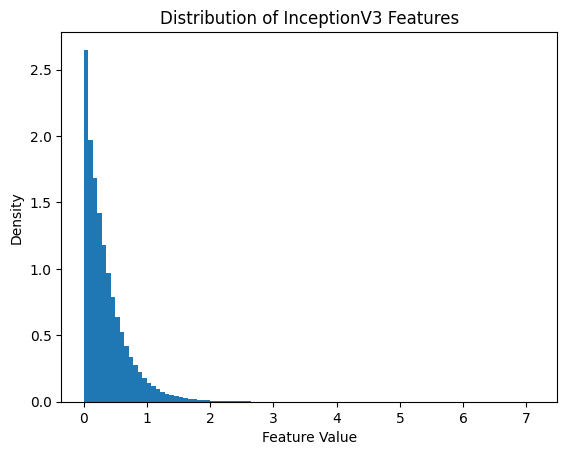

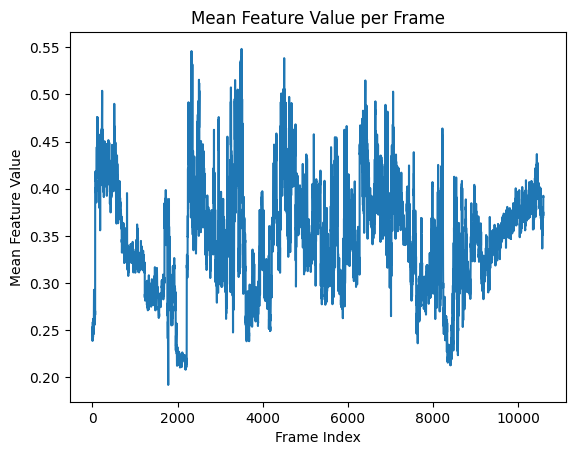

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the .npy file
npy_path = "/content/drive/MyDrive/InceptionV3_features/AwmHb44_ouw.npy"
features = np.load(npy_path)

# Plot histogram of all feature values
plt.hist(features.flatten(), bins=100, density=True)
plt.title("Distribution of InceptionV3 Features")
plt.xlabel("Feature Value")
plt.ylabel("Density")
plt.show()

# Plot mean feature value per frame
mean_features = np.mean(features, axis=1)
plt.plot(mean_features)
plt.title("Mean Feature Value per Frame")
plt.xlabel("Frame Index")
plt.ylabel("Mean Feature Value")
plt.show()

In [ ]:
if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    dataset_root = "/content/drive/MyDrive/CV_tvsum_frames/91IHQYk1IQM"
    output_dir = "/content/drive/MyDrive/InceptionV3_features"

    main(dataset_root, output_dir)

Mounted at /content/drive
Using device: cuda
Processing single video folder: 91IHQYk1IQM
InceptionV3 model loaded on device: cuda


Processing 91IHQYk1IQM: 100%|██████████| 3312/3312 [02:17<00:00, 24.16it/s]


Saved features to /content/drive/MyDrive/InceptionV3_features/91IHQYk1IQM.npy (shape: (3312, 2048))


In [ ]:
if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    dataset_root = "/content/drive/MyDrive/CV_tvsum_frames/3eYKfiOEJNs"
    output_dir = "/content/drive/MyDrive/InceptionV3_features"

    main(dataset_root, output_dir)

Mounted at /content/drive
Using device: cuda
Processing single video folder: 3eYKfiOEJNs
InceptionV3 model loaded on device: cuda


Processing 3eYKfiOEJNs: 100%|██████████| 4853/4853 [02:57<00:00, 27.29it/s]


Saved features to /content/drive/MyDrive/InceptionV3_features/3eYKfiOEJNs.npy (shape: (4853, 2048))


In [ ]:
if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    dataset_root = "/content/drive/MyDrive/CV_tvsum_frames/akI8YFjEmUw"
    output_dir = "/content/drive/MyDrive/InceptionV3_features"

    main(dataset_root, output_dir)

Mounted at /content/drive
Using device: cuda
Processing single video folder: akI8YFjEmUw
InceptionV3 model loaded on device: cuda


Processing akI8YFjEmUw: 100%|██████████| 3995/3995 [02:28<00:00, 26.84it/s]


Saved features to /content/drive/MyDrive/InceptionV3_features/akI8YFjEmUw.npy (shape: (3995, 2048))


In [ ]:
if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    dataset_root = "/content/drive/MyDrive/CV_tvsum_frames/cjibtmSLxQ4"
    output_dir = "/content/drive/MyDrive/InceptionV3_features"

    main(dataset_root, output_dir)

Mounted at /content/drive
Using device: cuda
Processing single video folder: cjibtmSLxQ4
InceptionV3 model loaded on device: cuda


Processing cjibtmSLxQ4: 100%|██████████| 19406/19406 [12:15<00:00, 26.37it/s]


Saved features to /content/drive/MyDrive/InceptionV3_features/cjibtmSLxQ4.npy (shape: (19406, 2048))


In [ ]:
# 7
if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    dataset_root = "/content/drive/MyDrive/CV_tvsum_frames/EE-bNr36nyA"
    output_dir = "/content/drive/MyDrive/InceptionV3_features"

    main(dataset_root, output_dir)

Mounted at /content/drive
Using device: cuda
Processing single video folder: EE-bNr36nyA
InceptionV3 model loaded on device: cuda


Processing EE-bNr36nyA: 100%|██████████| 2941/2941 [01:56<00:00, 25.24it/s]

Saved features to /content/drive/MyDrive/InceptionV3_features/EE-bNr36nyA.npy (shape: (2941, 2048))


In [ ]:
# E11zDS9XGzg 8
if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    dataset_root = "/content/drive/MyDrive/CV_tvsum_frames/E11zDS9XGzg"
    output_dir = "/content/drive/MyDrive/InceptionV3_features"

    main(dataset_root, output_dir)

Mounted at /content/drive
Using device: cuda
Processing single video folder: E11zDS9XGzg
InceptionV3 model loaded on device: cuda


Processing E11zDS9XGzg: 100%|██████████| 15307/15307 [09:51<00:00, 25.87it/s]


Saved features to /content/drive/MyDrive/InceptionV3_features/E11zDS9XGzg.npy (shape: (15307, 2048))


In [ ]:
 # 9
if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    dataset_root = "/content/drive/MyDrive/CV_tvsum_frames/-esJrBWj2d8"
    output_dir = "/content/drive/MyDrive/InceptionV3_features"

    main(dataset_root, output_dir)

Mounted at /content/drive
Using device: cuda
Processing single video folder: -esJrBWj2d8
InceptionV3 model loaded on device: cuda


Processing -esJrBWj2d8: 100%|██████████| 6912/6912 [04:54<00:00, 23.47it/s]


Saved features to /content/drive/MyDrive/InceptionV3_features/-esJrBWj2d8.npy (shape: (6912, 2048))


In [ ]:
# 10
if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    dataset_root = "/content/drive/MyDrive/CV_tvsum_frames/eQu1rNs0an0"
    output_dir = "/content/drive/MyDrive/InceptionV3_features"

    main(dataset_root, output_dir)

Mounted at /content/drive
Using device: cuda
Processing single video folder: eQu1rNs0an0
InceptionV3 model loaded on device: cuda


Processing eQu1rNs0an0: 100%|██████████| 4931/4931 [03:06<00:00, 26.37it/s]


Saved features to /content/drive/MyDrive/InceptionV3_features/eQu1rNs0an0.npy (shape: (4931, 2048))


In [ ]:
# 11
if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    dataset_root = "/content/drive/MyDrive/CV_tvsum_frames/byxOvuiIJV0"
    output_dir = "/content/drive/MyDrive/InceptionV3_features"

    main(dataset_root, output_dir)

Mounted at /content/drive
Using device: cuda
Processing single video folder: byxOvuiIJV0
InceptionV3 model loaded on device: cuda


Processing byxOvuiIJV0: 100%|██████████| 3705/3705 [02:37<00:00, 23.55it/s]


Saved features to /content/drive/MyDrive/InceptionV3_features/byxOvuiIJV0.npy (shape: (3705, 2048))


In [ ]:
# 12
if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    dataset_root = "/content/drive/MyDrive/CV_tvsum_frames/EYqVtI9YWJA"
    output_dir = "/content/drive/MyDrive/InceptionV3_features"

    main(dataset_root, output_dir)

Mounted at /content/drive
Using device: cuda
Processing single video folder: EYqVtI9YWJA
InceptionV3 model loaded on device: cuda


Processing EYqVtI9YWJA: 100%|██████████| 5939/5939 [04:02<00:00, 24.49it/s]


Saved features to /content/drive/MyDrive/InceptionV3_features/EYqVtI9YWJA.npy (shape: (5939, 2048))


In [ ]:
# iVt07TCkFM0 13
if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    dataset_root = "/content/drive/MyDrive/CV_tvsum_frames/iVt07TCkFM0"
    output_dir = "/content/drive/MyDrive/InceptionV3_features"

    main(dataset_root, output_dir)

Mounted at /content/drive
Using device: cuda
Processing single video folder: iVt07TCkFM0
InceptionV3 model loaded on device: cuda


Processing iVt07TCkFM0: 100%|██████████| 2500/2500 [01:38<00:00, 25.29it/s]


Saved features to /content/drive/MyDrive/InceptionV3_features/iVt07TCkFM0.npy (shape: (2500, 2048))


In [ ]:
#  14
if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    dataset_root = "/content/drive/MyDrive/CV_tvsum_frames/i3wAGJaaktw"
    output_dir = "/content/drive/MyDrive/InceptionV3_features"

    main(dataset_root, output_dir)

Mounted at /content/drive
Using device: cuda
Processing single video folder: i3wAGJaaktw
InceptionV3 model loaded on device: cuda


Processing i3wAGJaaktw: 100%|██████████| 4700/4700 [03:01<00:00, 25.82it/s]


Saved features to /content/drive/MyDrive/InceptionV3_features/i3wAGJaaktw.npy (shape: (4700, 2048))


In [ ]:
#  15
if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    dataset_root = "/content/drive/MyDrive/CV_tvsum_frames/Hl-__g2gn_A"
    output_dir = "/content/drive/MyDrive/InceptionV3_features"

    main(dataset_root, output_dir)

Mounted at /content/drive
Using device: cuda
Processing single video folder: Hl-__g2gn_A
InceptionV3 model loaded on device: cuda


Processing Hl-__g2gn_A:  19%|█▊        | 1096/5846 [02:11<01:41, 46.92it/s]

In [ ]:
 # NEW1

if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    dataset_root = "/content/drive/MyDrive/CV_tvsum_frames/kLxoNp-UchI"
    output_dir = "/content/drive/MyDrive/InceptionV3_features"

    main(dataset_root, output_dir)

Mounted at /content/drive
Using device: cuda
Processing single video folder: kLxoNp-UchI


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 156MB/s] 


InceptionV3 model loaded on device: cuda


Processing kLxoNp-UchI: 100%|██████████| 3896/3896 [02:40<00:00, 24.20it/s]


Saved features to /content/drive/MyDrive/InceptionV3_features/kLxoNp-UchI.npy (shape: (3896, 2048))


In [ ]:
 # NEW2

if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    dataset_root = "/content/drive/MyDrive/CV_tvsum_frames/jcoYJXDG9sw"
    output_dir = "/content/drive/MyDrive/InceptionV3_features"

    main(dataset_root, output_dir)

Mounted at /content/drive
Using device: cuda
Processing single video folder: jcoYJXDG9sw
InceptionV3 model loaded on device: cuda


Processing jcoYJXDG9sw: 100%|██████████| 5971/5971 [04:13<00:00, 23.55it/s]


Saved features to /content/drive/MyDrive/InceptionV3_features/jcoYJXDG9sw.npy (shape: (5971, 2048))


In [ ]:
 # NEW3

if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    dataset_root = "/content/drive/MyDrive/CV_tvsum_frames/qqR6AEXwxoQ"
    output_dir = "/content/drive/MyDrive/InceptionV3_features"

    main(dataset_root, output_dir)

Mounted at /content/drive
Using device: cuda
Processing single video folder: qqR6AEXwxoQ
InceptionV3 model loaded on device: cuda


Processing qqR6AEXwxoQ: 100%|██████████| 8073/8073 [07:20<00:00, 18.34it/s]


Saved features to /content/drive/MyDrive/InceptionV3_features/qqR6AEXwxoQ.npy (shape: (8073, 2048))


In [ ]:
 # NEW4

if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    dataset_root = "/content/drive/MyDrive/ata/CV_tvsum_frames/fWutDQy1nnY"
    output_dir = "/content/drive/MyDrive/InceptionV3_features"

    main(dataset_root, output_dir)

Mounted at /content/drive
Using device: cuda
Processing single video folder: fWutDQy1nnY
InceptionV3 model loaded on device: cuda


Processing fWutDQy1nnY: 100%|██████████| 17527/17527 [15:33<00:00, 18.77it/s]


Saved features to /content/drive/MyDrive/InceptionV3_features/fWutDQy1nnY.npy (shape: (17527, 2048))


In [ ]:
 # NEW5

if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    dataset_root = "/content/drive/MyDrive/ata/CV_tvsum_frames/J0nA4VgnoCo"
    output_dir = "/content/drive/MyDrive/InceptionV3_features"

    main(dataset_root, output_dir)

Mounted at /content/drive
Using device: cuda
Processing single video folder: J0nA4VgnoCo
InceptionV3 model loaded on device: cuda


Processing J0nA4VgnoCo: 100%|██████████| 14019/14019 [09:52<00:00, 23.65it/s]


Saved features to /content/drive/MyDrive/InceptionV3_features/J0nA4VgnoCo.npy (shape: (14019, 2048))


In [ ]:
 # NEW6

if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    dataset_root = "/content/drive/MyDrive/ata/CV_tvsum_frames/oDXZc0tZe04"
    output_dir = "/content/drive/MyDrive/InceptionV3_features"

    main(dataset_root, output_dir)

Mounted at /content/drive
Using device: cuda
Processing single video folder: oDXZc0tZe04
InceptionV3 model loaded on device: cuda


Processing oDXZc0tZe04: 100%|██████████| 11414/11414 [06:45<00:00, 28.14it/s]


Saved features to /content/drive/MyDrive/InceptionV3_features/oDXZc0tZe04.npy (shape: (11414, 2048))


In [ ]:
 # Old1

if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    dataset_root = "/content/drive/MyDrive/ata/CV_tvsum_frames/J0nA4VgnoCo"
    output_dir = "/content/drive/MyDrive/InceptionV3_features"

    main(dataset_root, output_dir)